## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import f1_score
from collections import defaultdict
import matplotlib.pyplot as plt

#%matplotlib inline

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=False):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_data_shape, dropout_rate, l2_rate):
    model = Sequential()
    
    #卷積層1與池化層1
    model.add(Conv2D(filters=1024, kernel_size=(3, 3), input_shape=input_data_shape, padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層2與池化層2
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層3與池化層3
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層4與池化層4
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層4與池化層5
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))
              
    #建立神經網路(平坦層、隱藏層、輸出層)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(l2_rate)))

    return model

In [6]:
## 超參數設定
# OPTIMIZER = ["sgd", "rmsprop", "adam", "adagrad"]
OPTIMIZER = ["adam", "rmsprop"]
LEARNING_RATE = 1e-3
L2_EXP = 1e-4
DROPOUT = [0.1, 0.2]
EPOCHS = 100
BATCH_SIZE = 32
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
earlystop = EarlyStopping(monitor="val_loss", 
                          patience=50, 
                          verbose=1
                          )

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

class f1sc(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

In [8]:
tra_loss = defaultdict(list)
val_loss = defaultdict(list)
tra_accu = defaultdict(list)
val_accu = defaultdict(list)

for i, drop_rate in enumerate(DROPOUT):
    for j, optr in enumerate(OPTIMIZER):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer=%s, ls=%.6f, dr=%.2f, bs=%d" % (optr, LEARNING_RATE, drop_rate, BATCH_SIZE))
        
        # create model
        model = build_mlp(x_train.shape[1:], drop_rate, L2_EXP)
        
        # optimizer
        if optr == "sgd":
            optimizer = optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=MOMENTUM, nesterov=True)

        if optr == "rmsprop":
            optimizer = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=None, decay=0.0)

        if optr == "adam":
            optimizer = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        if optr == "adagrad":
            optimizer = optimizers.Adagrad(lr=LEARNING_RATE, epsilon=None, decay=0.0)
    
        # compile model and training
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True, 
                  callbacks=[earlystop, model_ckpt, reduce_lr, log_f1sc])

        # Collect results
        exp_tag = "%s:%s" % (("exp_"+str(i)), str(optr))
        tra_loss[exp_tag].append(model.history.history["loss"])
        val_loss[exp_tag].append(model.history.history["val_loss"])
        
        tra_accu[exp_tag].append(model.history.history["acc"])
        val_accu[exp_tag].append(model.history.history["val_acc"])


Experiment with Optimizer=adam, ls=0.001000, dr=0.10, bs=32
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 309s 6ms/step - loss: 1.4051 - acc: 0.5144 - val_loss: 1.5947 - val_acc: 0.4531
Epoch 2/100
   32/50000 [..............................] - ETA: 4:52 - loss: 1.2994 - acc: 0.5938

c:\users\kevin\anaconda3\envs\tf_kevin\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 304s 6ms/step - loss: 0.9415 - acc: 0.6881 - val_loss: 1.0243 - val_acc: 0.6739
Epoch 3/100
50000/50000 [==============================] - 304s 6ms/step - loss: 0.7461 - acc: 0.7550 - val_loss: 0.9481 - val_acc: 0.6782
Epoch 4/100
50000/50000 [==============================] - 304s 6ms/step - loss: 0.6293 - acc: 0.7948 - val_loss: 0.7530 - val_acc: 0.7590
Epoch 5/100
50000/50000 [==============================] - 304s 6ms/step - loss: 0.5280 - acc: 0.8298 - val_loss: 0.8339 - val_acc: 0.7402
Epoch 6/100
50000/50000 [==============================] - 304s 6ms/step - loss: 0.4495 - acc: 0.8550 - val_loss: 0.8092 - val_acc: 0.7631
Epoch 7/100
50000/50000 [==============================] - 304s 6ms/step - loss: 0.3867 - acc: 0.8767 - val_loss: 1.0692 - val_acc: 0.7168
Epoch 8/100
50000/50000 [==============================] - 304s 6ms/step - loss: 0.3394 - acc: 0.8930 - val_loss: 0.7288 - val_acc: 0.7927
Epoch 9/100
50000/50000 [==============

50000/50000 [==============================] - 303s 6ms/step - loss: 0.0136 - acc: 0.9983 - val_loss: 0.9465 - val_acc: 0.8449
Epoch 56/100
50000/50000 [==============================] - 303s 6ms/step - loss: 0.0143 - acc: 0.9985 - val_loss: 0.9508 - val_acc: 0.8439
Epoch 57/100
50000/50000 [==============================] - 303s 6ms/step - loss: 0.0137 - acc: 0.9985 - val_loss: 0.9489 - val_acc: 0.8435
Epoch 58/100
50000/50000 [==============================] - 303s 6ms/step - loss: 0.0140 - acc: 0.9984 - val_loss: 0.9482 - val_acc: 0.8448

Epoch 00058: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 00058: early stopping
Experiment with Optimizer=rmsprop, ls=0.001000, dr=0.10, bs=32
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 299s 6ms/step - loss: 1.3714 - acc: 0.5233 - val_loss: 1.9117 - val_acc: 0.4600
Epoch 2/100
50000/50000 [==============================] - 298s 6ms/step - loss: 0.9288 - ac

50000/50000 [==============================] - 298s 6ms/step - loss: 0.0197 - acc: 0.9985 - val_loss: 0.9081 - val_acc: 0.8408
Epoch 51/100
50000/50000 [==============================] - 298s 6ms/step - loss: 0.0196 - acc: 0.9986 - val_loss: 0.9130 - val_acc: 0.8413
Epoch 52/100
50000/50000 [==============================] - 298s 6ms/step - loss: 0.0190 - acc: 0.9990 - val_loss: 0.9161 - val_acc: 0.8400

Epoch 00052: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 53/100
50000/50000 [==============================] - 298s 6ms/step - loss: 0.0185 - acc: 0.9990 - val_loss: 0.9099 - val_acc: 0.8408
Epoch 54/100
50000/50000 [==============================] - 298s 6ms/step - loss: 0.0189 - acc: 0.9989 - val_loss: 0.9088 - val_acc: 0.8410
Epoch 55/100
50000/50000 [==============================] - 298s 6ms/step - loss: 0.0187 - acc: 0.9990 - val_loss: 0.9079 - val_acc: 0.8400
Epoch 56/100
50000/50000 [==============================] - 298s 6ms/step - loss: 0.0193 - a

50000/50000 [==============================] - 303s 6ms/step - loss: 0.0345 - acc: 0.9926 - val_loss: 0.9760 - val_acc: 0.8393

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 42/100
50000/50000 [==============================] - 303s 6ms/step - loss: 0.0349 - acc: 0.9922 - val_loss: 0.9711 - val_acc: 0.8395
Epoch 43/100
50000/50000 [==============================] - 303s 6ms/step - loss: 0.0338 - acc: 0.9925 - val_loss: 0.9797 - val_acc: 0.8389
Epoch 44/100
50000/50000 [==============================] - 303s 6ms/step - loss: 0.0338 - acc: 0.9929 - val_loss: 0.9731 - val_acc: 0.8402
Epoch 45/100
50000/50000 [==============================] - 303s 6ms/step - loss: 0.0344 - acc: 0.9923 - val_loss: 0.9695 - val_acc: 0.8407
Epoch 46/100
50000/50000 [==============================] - 303s 6ms/step - loss: 0.0344 - acc: 0.9923 - val_loss: 0.9651 - val_acc: 0.8392

Epoch 00046: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 47/1

50000/50000 [==============================] - 302s 6ms/step - loss: 0.0878 - acc: 0.9854 - val_loss: 0.9605 - val_acc: 0.8381
Epoch 29/100
50000/50000 [==============================] - 302s 6ms/step - loss: 0.0836 - acc: 0.9855 - val_loss: 0.9802 - val_acc: 0.8329
Epoch 30/100
50000/50000 [==============================] - 302s 6ms/step - loss: 0.0797 - acc: 0.9868 - val_loss: 0.9821 - val_acc: 0.8350

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 31/100
50000/50000 [==============================] - 302s 6ms/step - loss: 0.0710 - acc: 0.9886 - val_loss: 0.9203 - val_acc: 0.8410
Epoch 32/100
50000/50000 [==============================] - 302s 6ms/step - loss: 0.0683 - acc: 0.9900 - val_loss: 0.9784 - val_acc: 0.8379
Epoch 33/100
50000/50000 [==============================] - 302s 6ms/step - loss: 0.0649 - acc: 0.9900 - val_loss: 0.9720 - val_acc: 0.8399
Epoch 34/100
50000/50000 [==============================] - 302s 6ms/step - loss: 0.0629 - a

## Plot loss history

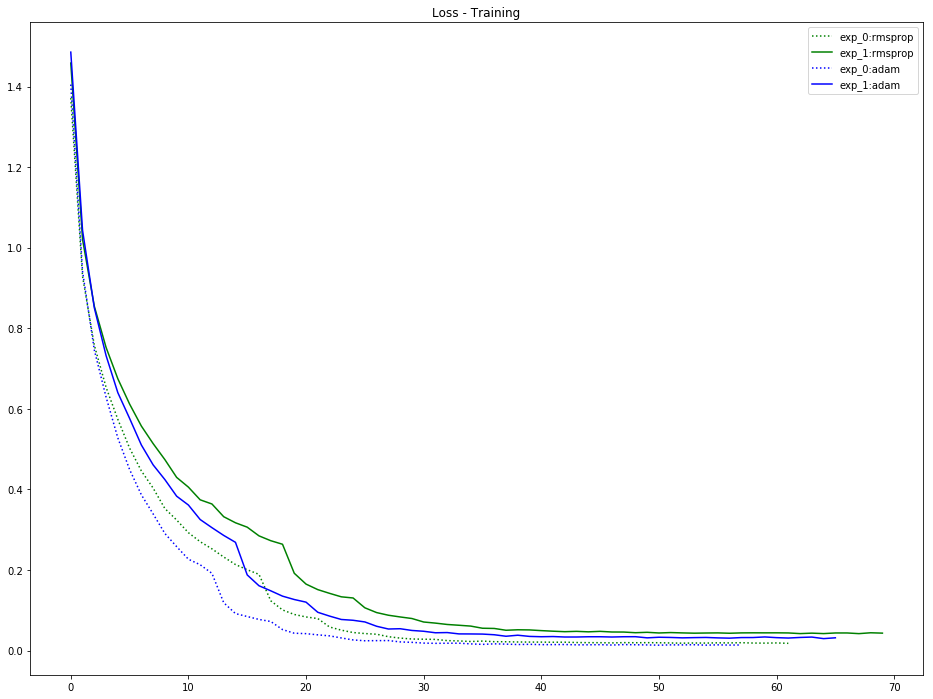

In [9]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(tra_loss["exp_0:sgd"][0])), tra_loss["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_1:sgd"][0])), tra_loss["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_2:sgd"][0])), tra_loss["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_3:sgd"][0])), tra_loss["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_4:sgd"][0])), tra_loss["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

plt.plot(range(len(tra_loss["exp_0:rmsprop"][0])), tra_loss["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
plt.plot(range(len(tra_loss["exp_1:rmsprop"][0])), tra_loss["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_2:rmsprop"][0])), tra_loss["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_3:rmsprop"][0])), tra_loss["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_4:rmsprop"][0])), tra_loss["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(tra_loss["exp_0:adam"][0])), tra_loss["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(tra_loss["exp_1:adam"][0])), tra_loss["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
# plt.plot(range(len(tra_loss["exp_2:adam"][0])), tra_loss["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(tra_loss["exp_3:adam"][0])), tra_loss["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(tra_loss["exp_4:adam"][0])), tra_loss["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(tra_loss["exp_0:adagrad"][0])), tra_loss["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_1:adagrad"][0])), tra_loss["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_2:adagrad"][0])), tra_loss["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_3:adagrad"][0])), tra_loss["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_4:adagrad"][0])), tra_loss["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Loss - Training")
plt.legend(loc="upper right")
plt.show()

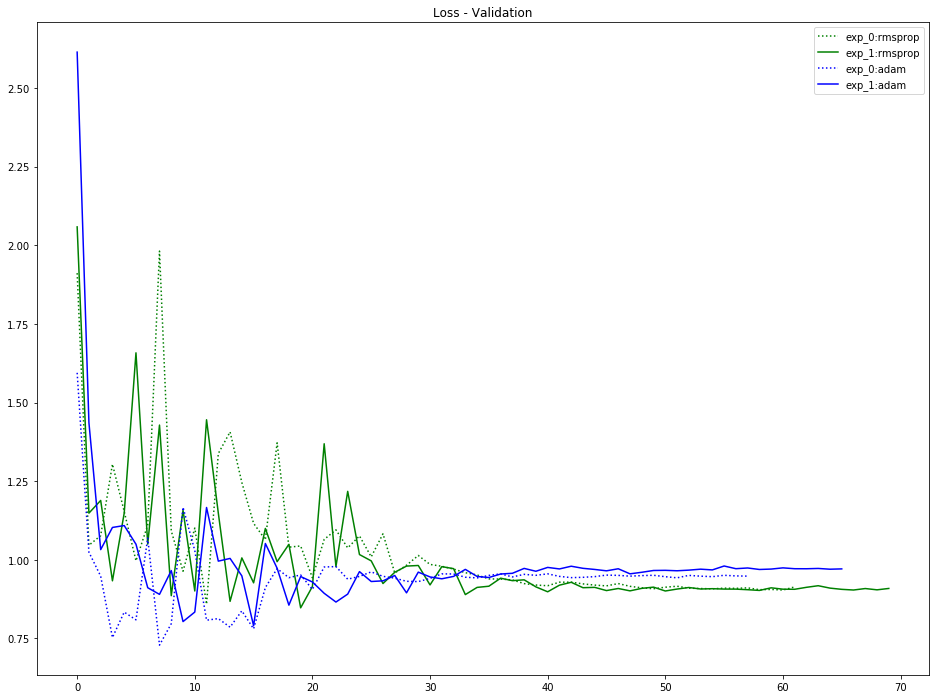

In [10]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(val_loss["exp_0:sgd"][0])), val_loss["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(val_loss["exp_1:sgd"][0])), val_loss["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(val_loss["exp_2:sgd"][0])), val_loss["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(val_loss["exp_3:sgd"][0])), val_loss["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(val_loss["exp_4:sgd"][0])), val_loss["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

plt.plot(range(len(val_loss["exp_0:rmsprop"][0])), val_loss["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
plt.plot(range(len(val_loss["exp_1:rmsprop"][0])), val_loss["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_2:rmsprop"][0])), val_loss["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_3:rmsprop"][0])), val_loss["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_4:rmsprop"][0])), val_loss["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(val_loss["exp_0:adam"][0])), val_loss["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(val_loss["exp_1:adam"][0])), val_loss["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
# plt.plot(range(len(val_loss["exp_2:adam"][0])), val_loss["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(val_loss["exp_3:adam"][0])), val_loss["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(val_loss["exp_4:adam"][0])), val_loss["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(val_loss["exp_0:adagrad"][0])), val_loss["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_1:adagrad"][0])), val_loss["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_2:adagrad"][0])), val_loss["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_3:adagrad"][0])), val_loss["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_4:adagrad"][0])), val_loss["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Loss - Validation")
plt.legend(loc="upper right")
plt.show()

### Optimizer=Adam, batch_size=64, dropout=0.2, 4.882812731921149e-07 有較低的loss

## Plot accu history

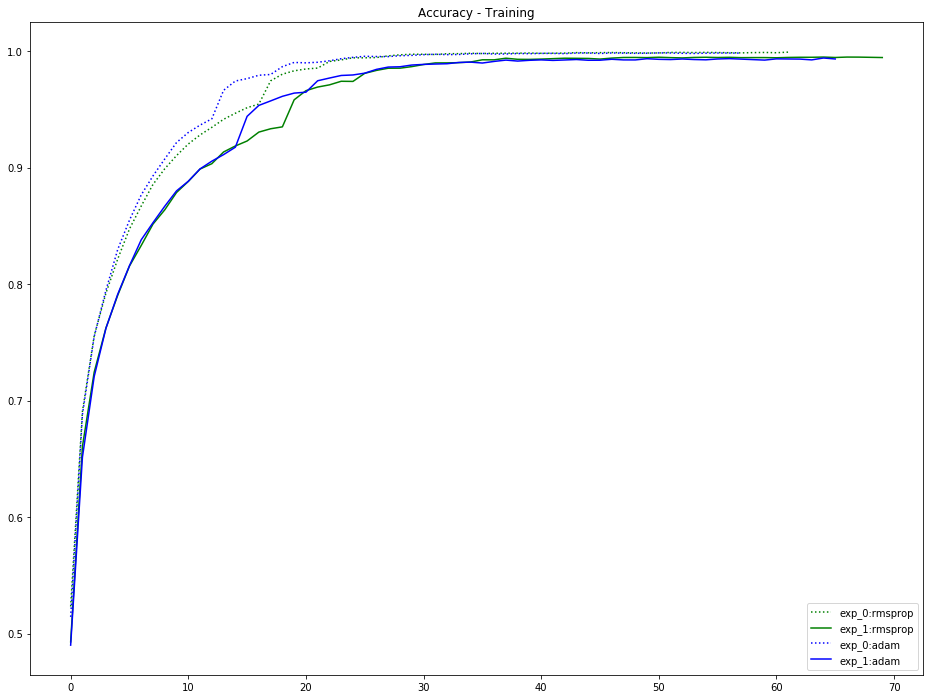

In [11]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(tra_accu["exp_0:sgd"][0])), tra_accu["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_1:sgd"][0])), tra_accu["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_2:sgd"][0])), tra_accu["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_3:sgd"][0])), tra_accu["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_4:sgd"][0])), tra_accu["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

plt.plot(range(len(tra_accu["exp_0:rmsprop"][0])), tra_accu["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
plt.plot(range(len(tra_accu["exp_1:rmsprop"][0])), tra_accu["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_2:rmsprop"][0])), tra_accu["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_3:rmsprop"][0])), tra_accu["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_4:rmsprop"][0])), tra_accu["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(tra_accu["exp_0:adam"][0])), tra_accu["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(tra_accu["exp_1:adam"][0])), tra_accu["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
# plt.plot(range(len(tra_accu["exp_2:adam"][0])), tra_accu["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(tra_accu["exp_3:adam"][0])), tra_accu["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(tra_accu["exp_4:adam"][0])), tra_accu["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(tra_accu["exp_0:adagrad"][0])), tra_accu["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_1:adagrad"][0])), tra_accu["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_2:adagrad"][0])), tra_accu["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_3:adagrad"][0])), tra_accu["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_4:adagrad"][0])), tra_accu["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Accuracy - Training")
plt.legend(loc="lower right")
plt.show()

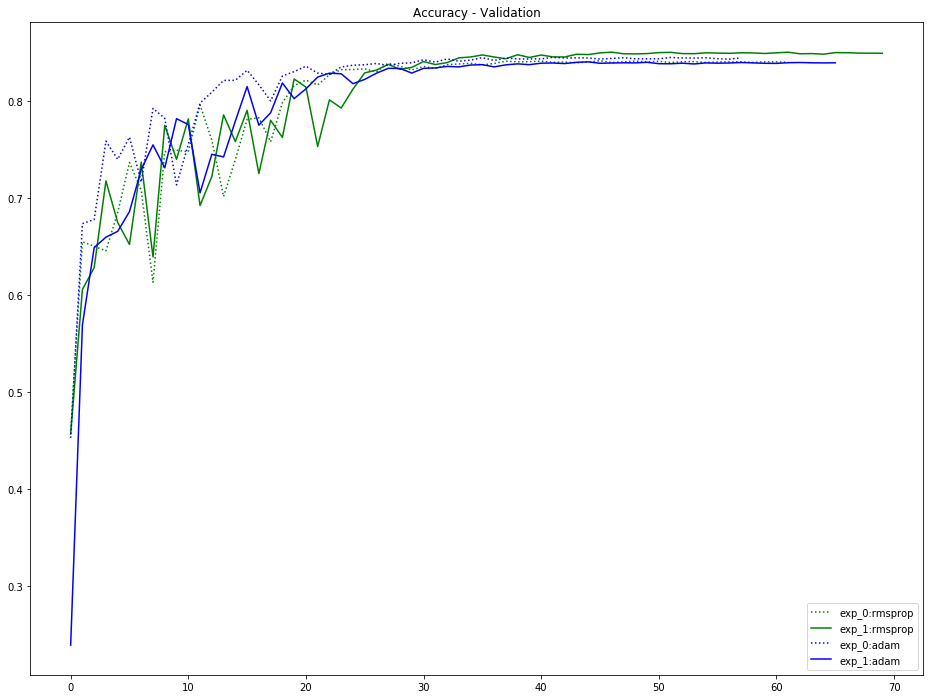

In [12]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(val_accu["exp_0:sgd"][0])), val_accu["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(val_accu["exp_1:sgd"][0])), val_accu["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(val_accu["exp_2:sgd"][0])), val_accu["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(val_accu["exp_3:sgd"][0])), val_accu["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(val_accu["exp_4:sgd"][0])), val_accu["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

plt.plot(range(len(val_accu["exp_0:rmsprop"][0])), val_accu["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
plt.plot(range(len(val_accu["exp_1:rmsprop"][0])), val_accu["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_2:rmsprop"][0])), val_accu["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_3:rmsprop"][0])), val_accu["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_4:rmsprop"][0])), val_accu["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(val_accu["exp_0:adam"][0])), val_accu["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(val_accu["exp_1:adam"][0])), val_accu["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
# plt.plot(range(len(val_accu["exp_2:adam"][0])), val_accu["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(val_accu["exp_3:adam"][0])), val_accu["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(val_accu["exp_4:adam"][0])), val_accu["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(val_accu["exp_0:adagrad"][0])), val_accu["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_1:adagrad"][0])), val_accu["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_2:adagrad"][0])), val_accu["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_3:adagrad"][0])), val_accu["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_4:adagrad"][0])), val_accu["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Accuracy - Validation")
plt.legend(loc="lower right")
plt.show()

### Optimizer=Adam, batch_size=64, dropout=0.1, learning rate=9.765625463842298e-07.有較好的準確率

## Load back

In [13]:
# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 13s 1ms/step


In [14]:
## '-' solid line style
## '--' dashed line style
## '-.' dash-dot line style
## ':' dotted line style
## '.' point marker
## ',' pixel marker
## 'o' circle marker
## 'v' triangle_down marker
## '^' triangle_up marker
## '<' triangle_left marker
## '>' triangle_right marker
## '1' tri_down marker
## '2' tri_up marker
## '3' tri_left marker
## '4' tri_right marker
## 's' square marker
## 'p' pentagon marker
## '*' star marker
## 'h' hexagon1 marker
## 'H' hexagon2 marker
## '+' plus marker
## 'x' x marker
## 'D' diamond marker
## 'd' thin_diamond marker
## '|' vline marker
## '_' hline marker
## 
## 'b' blue
## 'g' green
## 'r' red
## 'c' cyan
## 'm' magenta
## 'y' yellow
## 'k' black
## 'w' white